<a href="https://colab.research.google.com/github/sureshneethirajan/farmworx/blob/main/Suresh_Neethirajan_Facial_Emotion_Detection_Milestone%2B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Milestone 2**

We have built two Convolutional Neural Network architectures in Milestone 1. Here, we will further try to achieve better performance by increasing the number of parameters/weights. Therefore, we will start this Milestone with three popular Transfer Learning architectures, namely, VGG16, ResNet v2, and Efficient Net. Please feel free to explore other pre-trained models as well. Link to Keras documentation for pre-trained models - https://keras.io/api/applications/

**Note:** We will mount our drive and import our dataset once again for Milestone 2.

## **Mounting the Drive**

**NOTE:**  Please use Google Colab from your browser for this notebook. **Google.colab is not a library that can be downloaded locally on your device.**

In [1]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Importing the Libraries**

In [2]:
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

# Importing Deep Learning Libraries

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

### **Let us load the data**

**Note:** 
- You must download the dataset from the link provided on Olympus and upload the same on your Google drive before executing the code in the next cell.
- In case of any error, please make sure that the path of the file is correct as the path may be different for you.

In [3]:
# Storing the path of the data file from the Google drive
path = '/content/drive/MyDrive/Facial_emotion_images.zip'

# The data is provided as a zip file so we need to extract the files from the zip file
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall()

In [4]:
picture_size = 48
folder_path = "Facial_emotion_images/"

## **Transfer Learning Architectures**

In this section, we will create several Transfer Learning architectures. For the pre-trained models, we will select three popular architectures namely, VGG16, ResNet v2, and Efficient Net. The difference between these architectures and the previous architectures is that these will require 3 input channels while the earlier ones worked on 'grayscale' images. Therefore, we need to create new DataLoaders.

### **Creating our Data Loaders for Transfer Learning Architectures**

In this section, we are creating data loaders that we will use as inputs to our Neural Network. Unlike in Milestone 1, we will have to go with color_mode = 'rgb' as this is the required format for the transfer learning architectures.

In [5]:
batch_size  = 32
img_size = 48

datagen_train = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range = (0., 2.),
                                    rescale = 1./255,
                                    shear_range = 0.3)

train_set = datagen_train.flow_from_directory(folder_path + "train",
                                              target_size = (img_size, img_size),
                                              color_mode = 'rgb',
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              classes = ['happy', 'sad', 'neutral', 'surprise'],
                                              shuffle = True)


datagen_validation = ImageDataGenerator(horizontal_flip = True,
                                        brightness_range=(0.,2.),
                                        rescale=1./255,
                                        shear_range=0.3)

validation_set = datagen_validation.flow_from_directory(folder_path + "validation",
                                                        target_size = (img_size, img_size),
                                                        color_mode='rgb',
                                                        batch_size = batch_size,
                                                        class_mode = 'categorical',
                                                        shuffle = True)

datagen_test = ImageDataGenerator(horizontal_flip = True,
                                  brightness_range=(0.,2.),
                                  rescale=1./255,
                                  shear_range=0.3)


test_set = datagen_test.flow_from_directory(folder_path + "test",
                                            target_size = (img_size, img_size),
                                            color_mode = 'rgb' ,
                                            batch_size = batch_size,
                                            class_mode = 'categorical',
                                            shuffle = True)

Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


## **VGG16 Model**

### **Importing the VGG16 Architecture**

In [6]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Model

vgg = VGG16(include_top = False, weights = 'imagenet', input_shape = (48, 48, 3))
vgg.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                              

### **Model Building**

* In this model, we will import till the **'block5_pool'** layer of the VGG16 model. You can scroll down in the model summary and look for 'block5_pool'. You can choose any other layer as well.
* Then we will add a Flatten layer, which receives the output of the 'block5_pool' layer as its input.
* We will add a few Dense layers and use 'relu' activation function on them.
* You may use Dropout and BatchNormalization layers as well.
* Then we will add our last dense layer, which must have 4 neurons and a 'softmax' activation function.

In [7]:
transfer_layer = vgg.get_layer('block5_pool')
vgg.trainable = False

# Add classification layers on top of it  

x = transfer_layer.output
x = Conv2D(256, (1,1))(x)
x = LeakyReLU(alpha = 0.2)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(1,1)(x)
x = Dropout(rate = 0.3)(x)

x = Conv2D(512, (1,1))(x)
x = LeakyReLU(alpha = 0.2)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(1,1)(x)
x = Dropout(rate = 0.3)(x)

x = Conv2D(64, (1,1))(x)
x = LeakyReLU(alpha = 0.2)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(1,1)(x)
x = Dropout(rate = 0.3)(x)

# Flattenning the output from the 3rd block of the VGG16 model
x = Flatten()(x)

# Adding a Dense layer with 256 neurons
x = Dense(256) (x)
x = LeakyReLU(alpha = 0.2)(x)

# Add a Dense Layer with 128 neurons
x = Dense(128) (x)
x = LeakyReLU(alpha = 0.2)(x)

# Add a DropOut layer with Drop out ratio of 0.3
x = Dropout (rate=0.3) (x)

# Add a Dense Layer with 64 neurons
x = Dense(64) (x)
x = LeakyReLU(alpha = 0.2)(x)

# Add a Batch Normalization layer
x = BatchNormalization () (x)

# Adding the final dense layer with 4 neurons and use 'softmax' activation
pred = Dense(4, activation='softmax')(x)

vggmodel = Model(vgg.input, pred) # Initializing the model
vggmodel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

### **Compiling and Training the VGG16 Model**

In [8]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./vggmodel.h5", monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 20

In [9]:
# Write your code to compile the vggmodel. Use categorical crossentropy as the loss function, Adam Optimizer with 0.001 learning rate, and set metrics to 'accuracy'. 
vggmodel.compile(optimizer = Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = 'accuracy')

In [10]:
#history = # Write your code to fit your model. Use train_set as the training data and validation_set as the validation data. Train the model for 20 epochs.
history = vggmodel.fit(x= train_set, validation_data = validation_set, epochs = 20)


Epoch 1/20
473/473 [==============================] - 37s 54ms/step - loss: 1.3476 - accuracy: 0.3755 - val_loss: 1.2977 - val_accuracy: 0.3691
Epoch 2/20
473/473 [==============================] - 25s 52ms/step - loss: 1.2295 - accuracy: 0.4346 - val_loss: 1.2840 - val_accuracy: 0.3753
Epoch 3/20
473/473 [==============================] - 25s 52ms/step - loss: 1.1985 - accuracy: 0.4565 - val_loss: 1.2827 - val_accuracy: 0.3655
Epoch 4/20
473/473 [==============================] - 25s 52ms/step - loss: 1.1909 - accuracy: 0.4599 - val_loss: 1.2652 - val_accuracy: 0.4067
Epoch 5/20
473/473 [==============================] - 25s 52ms/step - loss: 1.1778 - accuracy: 0.4663 - val_loss: 1.2753 - val_accuracy: 0.3715
Epoch 6/20
473/473 [==============================] - 25s 52ms/step - loss: 1.1691 - accuracy: 0.4784 - val_loss: 1.2793 - val_accuracy: 0.4097
Epoch 7/20
473/473 [==============================] - 25s 52ms/step - loss: 1.1661 - accuracy: 0.4736 - val_loss: 1.2484 - val_accuracy:

### **Evaluating the VGG16 model**

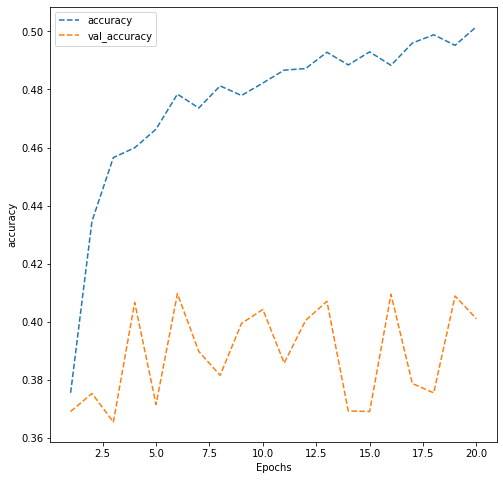

In [11]:
# Write your code to evaluate model performance on the test set
dict_hist = history.history
list_ep = [i for i in range(1, 21)]
plt.figure(figsize = (8, 8))
plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')
plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

**Think About It:**

- What do you infer from the general trend in the training performance? 
- Is the training accuracy consistently improving? 
- Is the validation accuracy also improving similarly?

**Observations and Insights:__**
Model is not learning well. Training data seems to be maxed out at .50, and is performing very poor at generalization (). There are multiple problems and issues with this model. The learning parameters are not great, as the training does not go back to the transfer model, and model appears to be flattened at 1x1 as it emerges out of maxpooling. This does not facilitate the possibilities for weight changes and further fine tuning the model. 

When varying parameters were used within the hidden layers, results and outcomes were similar. Upon changing the number of neurons randomly from 128 to 512 and again from 128 to 64, and by varying and changing the learning rate, the outcomes
were not great. Hyper parameters were also modified and changed for the data augmentation. The changing of the hyper parameters showed positive effect on the outcome. 

**Note: You can even go back and build your own architecture on top of the VGG16 Transfer layer and see if you can improve the performance**

## **ResNet V2 Model**

In [12]:
import tensorflow as tf
import tensorflow.keras.applications as ap
from tensorflow.keras import Model

Resnet = ap.ResNet101(include_top = False, weights = "imagenet", input_shape=(48,48,3))
Resnet.summary()

171446536/171446536 [==============================] - 1s 0us/step
Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1_conv[0][0]']             
                       

### **Model Building**

* In this model, we will import till the **'conv5_block3_add'** layer of the ResNet model. You can scroll down in the model summary and look for 'conv5_block3_add'. You can choose any other layer as well.
* Then we will add a Flatten layer, which receives the output of the 'conv5_block3_add' layer as its input.
* We will add a few Dense layers and use 'relu' activation function on them.
* You may use Dropout and BatchNormalization layers as well.
* Then we will add our last dense layer, which must have 4 neurons and a 'softmax' activation function.

In [ ]:
from tensorflow.python.compiler import xla
transfer_layer_Resnet = Resnet.get_layer('conv5_block3_add')
Resnet.trainable=False

# Add classification layers on top of it
x = MaxPooling2D(2,2) (transfer_layer_Resnet.output)

# Flattenning the output from the 3rd block of the VGG16 model
x = Flatten()(x)

# Add a Dense layer with 256 neurons
x = Dense(256, activation = 'relu')(x)
x = LeakyReLU(alpha = 0.2) (x)
x = BatchNormalization () (x)
X = Dropout (rate = 0.3) (x)

# Add a Dense Layer with 128 neurons
x = Dense (128) (x)
x = LeakyReLU(alpha = 0.2) (x)

# Add a DropOut layer with Drop out ratio of 0.3
x = Dropout (rate = 0.3) (x)

# Add a Dense Layer with 64 neurons
x = Dense (64) (x)
x = LeakyReLU(alpha = 0.2)(x)

# Add a Batch Normalization layer
x = BatchNormalization ()(x)

# Add the final dense layer with 4 neurons and use a 'softmax' activation
pred = Dense(4, activation = 'softmax')(x)

resnetmodel = Model(Resnet.input, pred) # Initializing the model

### **Compiling and Training the Model**

In [14]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./Resnetmodel.h5", monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                               min_delta = 0,
                               patience = 3,
                               verbose = 1,
                               restore_best_weights = True)

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                                        factor = 0.2,
                                        patience = 3,
                                        verbose = 1,
                                        min_delta = 0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 10

In [15]:
# Write your code to compile your resnetmodel. Use categorical crossentropy as your loss function, Adam Optimizer with 0.001 learning rate, and set your metrics to 'accuracy'. 
resnetmodel.compile(optimizer = Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = 'accuracy')


In [16]:
# Write your code to fit your model. Use train_set as your training data and validation_set as your validation data. Train your model for 20 epochs.
history = resnetmodel.fit(x= train_set, validation_data = validation_set, epochs = 20)

Epoch 1/20
473/473 [==============================] - 34s 58ms/step - loss: 1.3821 - accuracy: 0.3394 - val_loss: 2.4231 - val_accuracy: 0.2413
Epoch 2/20
473/473 [==============================] - 25s 53ms/step - loss: 1.2890 - accuracy: 0.3862 - val_loss: 5.7078 - val_accuracy: 0.1601
Epoch 3/20
473/473 [==============================] - 25s 53ms/step - loss: 1.2614 - accuracy: 0.4095 - val_loss: 2.9600 - val_accuracy: 0.2096
Epoch 4/20
473/473 [==============================] - 25s 53ms/step - loss: 1.2435 - accuracy: 0.4224 - val_loss: 4.0751 - val_accuracy: 0.1607
Epoch 5/20
473/473 [==============================] - 25s 54ms/step - loss: 1.2298 - accuracy: 0.4311 - val_loss: 2.6947 - val_accuracy: 0.2602
Epoch 6/20
473/473 [==============================] - 26s 54ms/step - loss: 1.2240 - accuracy: 0.4396 - val_loss: 1.4363 - val_accuracy: 0.3984
Epoch 7/20
473/473 [==============================] - 25s 53ms/step - loss: 1.2118 - accuracy: 0.4440 - val_loss: 2.1988 - val_accuracy:

### **Evaluating the ResNet Model**

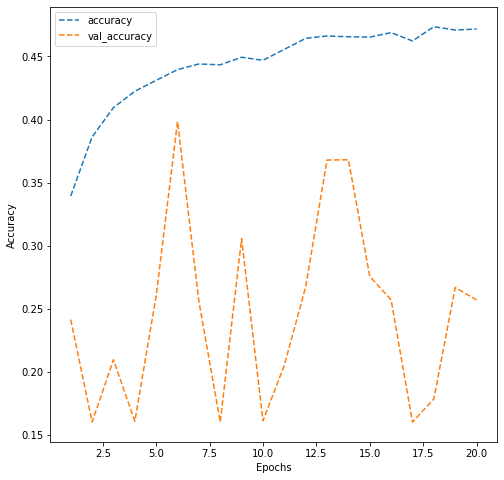

In [18]:
# Write your code to evaluate model performance on the test set
dict_hist = history.history
list_ep = [i for i in range(1, 21)]
plt.figure(figsize = (8, 8))
plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')
plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

**Observations and Insights:__**

**Note: You can even go back and build your own architecture on top of the ResNet Transfer layer and see if you can improve the performance.**
After few back and forth revisions with varying parameters, and changing multiple options, ResNet provided only little improvement in accuracy and hence a marginal advancement from previous model. The sensitivity is very high to overfitting, and there are issues associated to additional convolutional layers for refinement. The addition of hidden layers does not help in the generalization. 

## **EfficientNet Model**

In [19]:
import tensorflow as tf
import tensorflow.keras.applications as ap
from tensorflow.keras import Model
EfficientNet = ap.EfficientNetV2B2(include_top=False,weights="imagenet", input_shape= (48, 48, 3))

EfficientNet.summary()

35839040/35839040 [==============================] - 0s 0us/step
Model: "efficientnetv2-b2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 48, 48, 3)    0           ['input_3[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 48, 48, 3)    0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 24, 24, 32)   864         ['normalization[0][0]']          
                 

### **Model Building**

**Build your own Architecture on top of the transfer layer. Be sure to have a Flatten layer after your transfer layer and also make sure you have 4 neurons and softmax activation function in your last dense layer**

In [24]:
transfer_layer_EfficientNet = EfficientNet.get_layer('block6e_expand_activation')
EfficientNet.trainable = False
x = transfer_layer_EfficientNet.output
x = BatchNormalization()(x)
x = MaxPooling2D(1,1)(x)
x = Dropout(rate = 0.3)(x)

# Add your Flatten layer.
x = Flatten() (x)

# Add your Dense layers and/or BatchNormalization and Dropout layers
x = Dense(64, activation = LeakyReLU(alpha = 0.2))(x)
x = BatchNormalization()(x)
x = Dropout(rate = 0.3)(x)
x = Dense(512, activation = LeakyReLU(alpha = 0.2))(x)
x = BatchNormalization() (x)
x = Dropout(rate = 0.3)(x)
x = Dense(128, activation = LeakyReLU(alpha = 0.2))(x)
x = BatchNormalization()(x)
x = Dropout(rate = 0.3)(x)

# Add your final Dense layer with 4 neurons and softmax activation function.
pred = Dense(4, activation = 'softmax')(x)

Efficientnetmodel = Model(EfficientNet.input, pred)

### **Compiling and Training the Model**

In [25]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./Efficientnetmodel.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                               min_delta = 0,
                               patience = 3,
                               verbose = 1,
                               restore_best_weights = True)  

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                                        factor = 0.3,
                                        patience = 5,
                                        verbose = 1,
                                        min_delta = 0.01)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

epochs = 20

In [26]:
# Write your code to compile your Efficientnetmodel. Use categorical crossentropy as your loss function, Adam Optimizer with 0.001 learning rate, and set your metrics to 'accuracy'.
Efficientnetmodel.compile(loss='categorical_crossentropy',
                          optimizer = Adam(learning_rate=0.001),
                          metrics=['accuracy'])


In [28]:
# Write your code to fit your model. Use train_set as your training data and validation_set as your validation data. Train your model for 20 epochs.
history = Efficientnetmodel.fit(x= train_set, validation_data = validation_set, epochs = 20)                         

Epoch 1/20
473/473 [==============================] - 34s 57ms/step - loss: 1.6254 - accuracy: 0.2581 - val_loss: 1.3742 - val_accuracy: 0.2289
Epoch 2/20
473/473 [==============================] - 25s 53ms/step - loss: 1.4539 - accuracy: 0.2614 - val_loss: 1.3828 - val_accuracy: 0.2297
Epoch 3/20
473/473 [==============================] - 25s 53ms/step - loss: 1.4154 - accuracy: 0.2610 - val_loss: 1.3839 - val_accuracy: 0.2311
Epoch 4/20
473/473 [==============================] - 25s 53ms/step - loss: 1.4016 - accuracy: 0.2582 - val_loss: 1.3715 - val_accuracy: 0.2714
Epoch 5/20
473/473 [==============================] - 25s 53ms/step - loss: 1.3931 - accuracy: 0.2674 - val_loss: 1.3764 - val_accuracy: 0.2333
Epoch 6/20
473/473 [==============================] - 25s 53ms/step - loss: 1.3921 - accuracy: 0.2619 - val_loss: 1.3793 - val_accuracy: 0.2443
Epoch 7/20
473/473 [==============================] - 25s 53ms/step - loss: 1.3910 - accuracy: 0.2604 - val_loss: 1.3699 - val_accuracy:

### **Evaluating the EfficientnetNet Model**

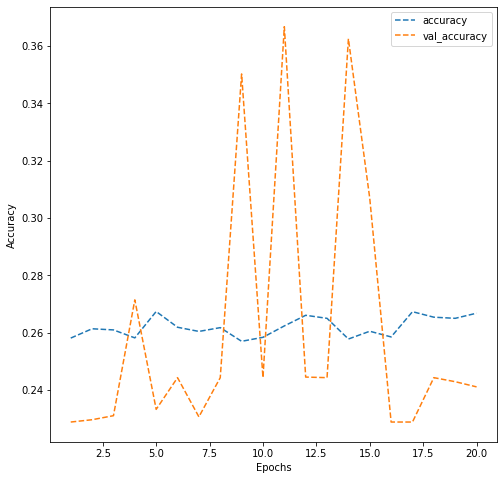

In [30]:
# Write your code to evaluate the model performance on the test set
dict_hist = history.history
list_ep = [i for i in range(1, 21)]
plt.figure(figsize = (8, 8))
plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')
plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

**Observations and Insights:__**

**Note: You can even go back and build your own architecture on top of the VGG16 Transfer layer and see if you can improve the performance.**

**Think About It:**

* What is your overall performance of these Transfer Learning Architectures? Can we draw a comparison of these models' performances. Are we satisfied with the accuracies that we have received? * Do you think our issue lies with 'rgb' color_mode?

Based on the changes in the hyperparameters and the adjustments given, the model performed fine and appears to continue the learning. It should also be pointed out that the model becomes sensitive to overfitting. Multiple convo and hidden  layers were employed, but they were changed and removed after observing the preliminary results. 

After several models, the results are still not satisfactory By mixing the earlier model, by changing the hyper parameters and by working through factors, the transfer training results are not very good and shows only poor performance.  Although the learning rate is steady, regarding the generalization the improvement is not good.

Because multiple pre-trained models were employed and evaluated, now the focus is on building a bit more complex CNN architecture to further assess the model along with hyperparameters to test the possibility for achieving the better performance with higher accuracy results. 

The provided dataset is primarily made of grayscale images. Regarding the rgb colour space, the accuracy may be influenced by the angle and light source of the data which may in turnreduces the detection classification accuracy. In the results obtained so far, rgb does not have any influence,
because in the milestone 1, no significant difference was noticed between grayscale and rgb assessments. rgb is important and appropriate for colour statistics processing. If there are variations in the illuminations of facial images among the dataset, then yes rgb can have influence on the assessment accuracy.

Now that we have tried multiple pre-trained models, let's build a complex CNN architecture and see if we can get better performance.

## **Building a Complex Neural Network Architecture**

In this section, we will build a more complex Convolutional Neural Network Model that has close to as many parameters as we had in our Transfer Learning Models. However, we will have only 1 input channel for our input images.

## **Creating our Data Loaders**

In this section, we are creating data loaders which we will use as inputs to the more Complicated Convolutional Neural Network. We will go ahead with color_mode = 'grayscale'.

In [46]:
batch_size  = 32
img_size = 48

datagen_train = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range = (0., 2.),
                                    rescale = 1./255,
                                    shear_range = 0.3)

train_set = datagen_train.flow_from_directory(folder_path + "train",
                                              target_size = (img_size, img_size),
                                              color_mode = 'grayscale',
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              classes = ['happy', 'sad', 'neutral', 'surprise'],
                                              shuffle = True)

datagen_validation = ImageDataGenerator(horizontal_flip = True,
                                        brightness_range=(0.,2.),
                                        rescale=1./255,
                                        shear_range=0.3)

validation_set = datagen_validation.flow_from_directory(folder_path + "validation",
                                                        target_size = (img_size, img_size),
                                                        color_mode = 'grayscale',
                                                        batch_size = batch_size,
                                                        class_mode = 'categorical',
                                                        shuffle = True)

datagen_test = datagen_test = ImageDataGenerator(horizontal_flip = True,
                                                 brightness_range=(0.,2.),
                                                 rescale=1./255,
                                                 shear_range=0.3)

test_set = datagen_test.flow_from_directory(folder_path + "test",
                                            target_size = (img_size, img_size),
                                            color_mode = 'grayscale',
                                            batch_size = batch_size,
                                            class_mode = 'categorical',
                                            shuffle = True)


Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


### **Model Building**

* In this network, we plan to have 5 Convolutional Blocks
* Add first Conv2D layer with **64 filters** and a **kernel size of 2**. Use the 'same' padding and provide the **input shape = (48, 48, 1)**. Use **'relu' activation**.
* Add your BatchNormalization layer followed by a LeakyRelU layer with Leaky ReLU parameter of **0.1**
* Add MaxPooling2D layer with **pool size = 2**.
* Add a Dropout layer with a Dropout Ratio of **0.2**. This completes the first Convolutional block.
* Add a second Conv2D layer with **128 filters** and a **kernel size of 2**. Use the **'same' padding** and **'relu' activation.**
* Follow this up with a similar BatchNormalization, LeakyRelU, Maxpooling2D, and Dropout layer like above to complete your second Convolutional Block.
* Add a third Conv2D layer with **512 filters** and a **kernel size of 2**. Use the **'same' padding** and **'relu' activation.** Once again, follow it up with a BatchNormalization, LeakyRelU, Maxpooling2D, and Dropout layer to complete your third Convolutional block.
* Add a fourth block, with the Conv2D layer having **512 filters**.
* Add the fifth block, having **128 filters**.
* Then add your Flatten layer, followed by your Dense layers.
* Add your first Dense layer with **256 neurons** followed by a BatchNormalization layer, a **'relu'** Activation, and a Dropout layer. This forms your first Fully Connected block
* Add your second Dense layer with **512 neurons**, again followed by a BatchNormalization layer, **relu** activation, and a Dropout layer.
* Add your final Dense layer with 4 neurons.
* Compile your model with the optimizer of your choice.

In [52]:
no_of_classes = 4

model3 = Sequential()

# Add 1st CNN Block
model3.add(Conv2D(64, (2,2), padding = 'same', activation = 'relu', input_shape = (48, 48, 1)))
model3.add(BatchNormalization())
model3.add(LeakyReLU(alpha = 0.2))
model3.add(MaxPooling2D(2,2))
model3.add(Dropout(rate = 0.2))

# Add 2nd CNN Block
model3.add(Conv2D(128, (2,2), padding = 'same', activation = 'relu'))
model3.add(BatchNormalization())
model3.add(LeakyReLU(alpha = 0.2))
model3.add(MaxPooling2D(2,2))
model3.add(Dropout(rate = 0.2))

# Add 3rd CNN Block
model3.add(Conv2D(512, (2,2), padding = 'same', activation = 'relu'))
model3.add(BatchNormalization())
model3.add(LeakyReLU(alpha = 0.2))
model3.add(MaxPooling2D(2,2))
model3.add(Dropout(rate = 0.2))

# Add 4th CNN Block
model3.add(Conv2D(512, (2,2), padding = 'same', activation = 'relu'))
model3.add(BatchNormalization())
model3.add(LeakyReLU(alpha = 0.2))
model3.add(MaxPooling2D(2,2))
model3.add(Dropout(rate = 0.2))

# Add 5th CNN Block
model3.add(Conv2D(256, (2,2), padding = 'same', activation = 'relu'))
model3.add(BatchNormalization())
model3.add(LeakyReLU(alpha = 0.2))
model3.add(MaxPooling2D(2,2))
model3.add(Dropout(rate = 0.2))

model3.add(Conv2D(512, (2,2), padding = 'same', activation = 'relu'))
model3.add(BatchNormalization())
model3.add(LeakyReLU(alpha = 0.2))
model3.add(MaxPooling2D(1,1))
model3.add(Dropout(rate = 0.2))

model3.add(Flatten())

# First fully connected layer
model3.add(Dense(256))
model3.add(LeakyReLU(alpha = 0.2))
model3.add(BatchNormalization())
model3.add(Dropout(rate = 0.2))

# Second fully connected layer
model3.add(Dense(512))
model3.add(LeakyReLU(alpha = 0.2))
model3.add(BatchNormalization())
model3.add(Dropout(rate = 0.2))

model3.add(Dense(64))
model3.add(LeakyReLU(alpha = 0.2))
model3.add(BatchNormalization())
model3.add(Dropout(rate = 0.2))

model3.add(Dense(no_of_classes, activation = 'softmax'))
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 48, 48, 64)        320       
                                                                 
 batch_normalization_30 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_28 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 24, 24, 128)      

### **Compiling and Training the Model**

In [53]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

epochs = 35

steps_per_epoch = train_set.n//train_set.batch_size
validation_steps = validation_set.n//validation_set.batch_size

checkpoint = ModelCheckpoint("model3.h5", monitor = 'val_accuracy',
                            save_weights_only = True, model = 'max', verbose = 1)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 2, min_lr = 0.0001 , model = 'auto')

callbacks = [checkpoint, reduce_lr]

In [54]:
# Write your code to compile your model3. Use categorical crossentropy as the loss function, Adam Optimizer with 0.003 learning rate, and set metrics to 'accuracy'.
model3.compile(optimizer = Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics ='accuracy')

In [56]:
### Write your code to fit your model. Use train_set as the training data and validation_set as the validation data. Train your model for 35 epochs.
history = model3.fit(x=train_set, validation_data = validation_set, epochs = 35)

Epoch 1/35
473/473 [==============================] - 19s 37ms/step - loss: 1.5655 - accuracy: 0.2604 - val_loss: 1.4389 - val_accuracy: 0.2710
Epoch 2/35
473/473 [==============================] - 17s 36ms/step - loss: 1.4258 - accuracy: 0.2826 - val_loss: 1.3320 - val_accuracy: 0.3390
Epoch 3/35
473/473 [==============================] - 17s 36ms/step - loss: 1.3083 - accuracy: 0.3608 - val_loss: 1.3316 - val_accuracy: 0.3566
Epoch 4/35
473/473 [==============================] - 17s 36ms/step - loss: 1.1955 - accuracy: 0.4483 - val_loss: 1.1725 - val_accuracy: 0.4356
Epoch 5/35
473/473 [==============================] - 17s 36ms/step - loss: 1.0907 - accuracy: 0.5128 - val_loss: 1.0659 - val_accuracy: 0.4838
Epoch 6/35
473/473 [==============================] - 17s 36ms/step - loss: 1.0169 - accuracy: 0.5581 - val_loss: 1.0448 - val_accuracy: 0.4969
Epoch 7/35
473/473 [==============================] - 17s 36ms/step - loss: 0.9844 - accuracy: 0.5705 - val_loss: 1.1577 - val_accuracy:

### **Evaluating the Model on Test Set**

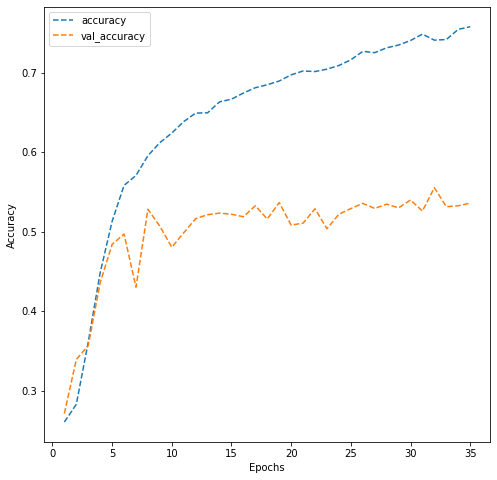

In [58]:
# Write your code to evaluate the model performance on the test set
dict_hist = history.history
list_ep = [i for i in range(1, 36)]
plt.figure(figsize = (8,8))
plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')
plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

**Observations and Insights:__**
Model is good (above 75%) interms of its responsiveness to adjustments in the plarameters and hyper-parameters, however it is not good in generalization. The model provides flexibility and better results. This model shall be used as a final model for refining and tuning for better accuracy and higher classification results.

### **Plotting the Confusion Matrix for the chosen final model**

Found 128 images belonging to 4 classes.
4/4 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.74      0.81      0.78        32
           1       0.61      0.72      0.66        32
           2       0.65      0.53      0.59        32
           3       0.90      0.81      0.85        32

    accuracy                           0.72       128
   macro avg       0.72      0.72      0.72       128
weighted avg       0.72      0.72      0.72       128



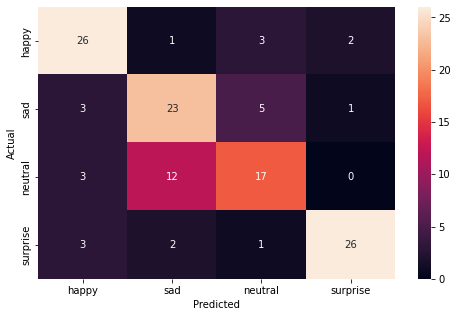

In [59]:
# Plot the confusion matrix and generate a classification report for the model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
test_set = datagen_test.flow_from_directory(folder_path + "test",
                                                              target_size = (img_size,img_size),
                                                              color_mode = 'grayscale',
                                                              batch_size = 128,
                                                              class_mode = 'categorical',
                                                              classes = ['happy', 'sad', 'neutral', 'surprise'],
                                                              shuffle = True) 
test_images, test_labels = next(test_set)

# Write the name of your chosen model in the blank
pred = model3.predict(test_images)
pred = np.argmax(pred, axis = 1) 
y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['happy', 'sad', 'neutral', 'surprise'], yticklabels = ['happy', 'sad', 'neutral', 'surprise'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Observations and Insights:__**
The dataset images from the sad class and the neutral class appears to have classification issues, followed by the happy and surprise classes. The surprise and happy class dataset are better classified. 

## **Conclusion:____________**
Model 3 provides better results for the provided dataset along with flexibility for refining via hyperparameters. Because the goal is to increase the accuracy to over 90%, a bit more adjustments and refinements by fine tuning the hyperparameters along with additional approaches are necessary. 

### **Insights**

### **Refined insights**:
- What are the most meaningful insights from the data relevant to the problem?

### **Comparison of various techniques and their relative performance**:
- How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?

### **Proposal for the final solution design**:
- What model do you propose to be adopted? Why is this the best solution to adopt?